# Assignment 3: Process Mining Analysis


Run the cell below to ensure all necessary libraries are installed in your current environment.


In [2]:

# Auto-install dependencies
%pip install pm4py pandas matplotlib seaborn




[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:

import pm4py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Use the smaller log as permitted
log_path = "A3-Artifacts/DhanaLoanApplication201607.xes"
log_offer_path = "A3-Artifacts/DhanaOfferObject.xes"

# Load Logs
print("Loading data...")
log = pm4py.read_xes(log_path)
df = pm4py.convert_to_dataframe(log)
print("Data loaded.")



Loading data...


parsing log, completed traces :: 100%|██████████| 10124/10124 [00:09<00:00, 1110.69it/s]


Data loaded.


## Part 1: Exploratory Analysis


--- Task 1 ---
Attributes in A_Create Application: ['lifecycle:transition', 'time:timestamp', 'Action', 'org:resource', 'EventID', 'concept:name', 'EventOrigin', 'case:concept:name', 'case:variant', 'case:variant-index', 'case:creator', 'case:LoanGoal', 'case:ApplicationType', 'case:RequestedAmount']

--- Task 2 ---
                        time:timestamp            concept:name
41431 2016-01-23 14:35:52.357000+00:00    A_Create Application
41432 2016-01-23 14:35:52.391000+00:00             A_Submitted
41433 2016-01-23 14:35:52.632000+00:00          W_Handle leads
41434 2016-01-23 14:36:28.439000+00:00          W_Handle leads
41435 2016-01-23 14:36:28.448000+00:00  W_Complete application

--- Task 3 ---
case:LoanGoal
Car                       4104
Home improvement          2805
Existing loan takeover    2268
Name: count, dtype: int64

--- Task 4 ---


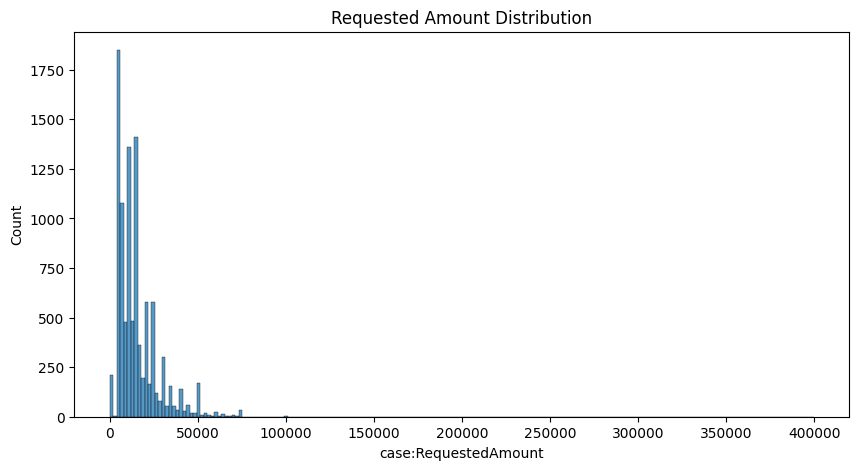


--- Task 5 ---


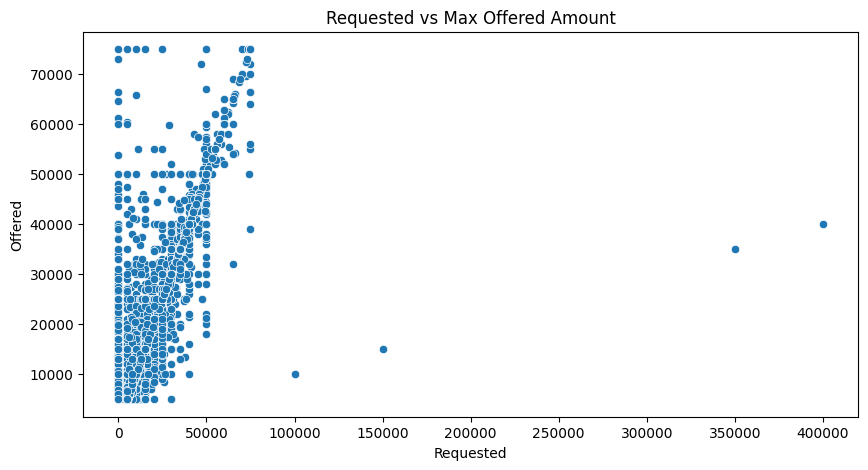


--- Task 6 ---


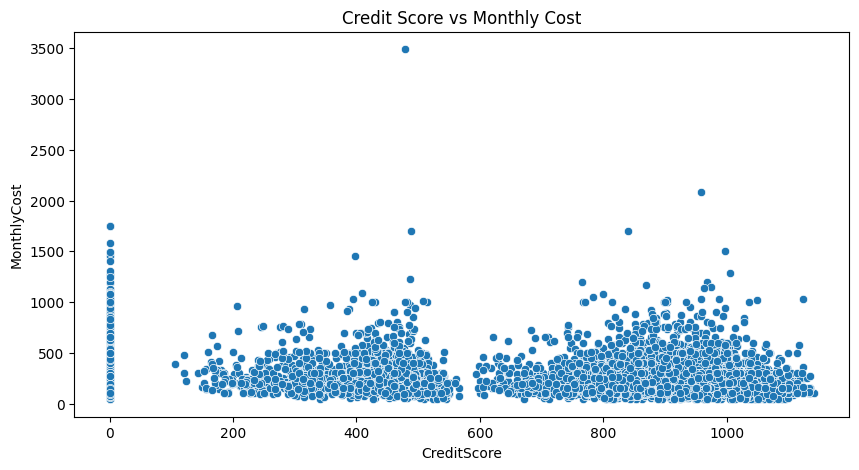

In [4]:

# Task 1: Schemas & Attributes
print("--- Task 1 ---")
create_app = df[df['concept:name'] == 'A_Create Application']
print("Attributes in A_Create Application:", create_app.dropna(axis=1, how='all').columns.tolist())

# Task 2: Inspect Specific Case
print("\n--- Task 2 ---")
case_177 = df[df['case:concept:name'] == 'Application_177461216'].sort_values('time:timestamp')
print(case_177[['time:timestamp', 'concept:name']].head())

# Task 3: Top Loan Goals
print("\n--- Task 3 ---")
case_attrs = df.groupby('case:concept:name').first()
if 'case:LoanGoal' in case_attrs.columns:
    print(case_attrs['case:LoanGoal'].value_counts().head(3))

# Task 4: Requested Amount Distribution
print("\n--- Task 4 ---")
if 'case:RequestedAmount' in case_attrs.columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(case_attrs['case:RequestedAmount'].dropna())
    plt.title("Requested Amount Distribution")
    plt.show()

# Task 5: Requested vs Max Offered
print("\n--- Task 5 ---")
if 'OfferedAmount' in df.columns:
    max_offered = df.groupby('case:concept:name')['OfferedAmount'].max()
    comp_df = pd.DataFrame({'Requested': case_attrs['case:RequestedAmount'], 'Offered': max_offered}).dropna()
    plt.figure(figsize=(10, 5))
    sns.scatterplot(data=comp_df, x='Requested', y='Offered')
    plt.title("Requested vs Max Offered Amount")
    plt.show()

# Task 6: Credit Score vs Monthly Cost
print("\n--- Task 6 ---")
if 'CreditScore' in df.columns and 'MonthlyCost' in df.columns:
    agg = df.groupby('case:concept:name')[['CreditScore', 'MonthlyCost']].mean().dropna()
    plt.figure(figsize=(10, 5))
    sns.scatterplot(data=agg, x='CreditScore', y='MonthlyCost')
    plt.title("Credit Score vs Monthly Cost")
    plt.show()



## Part 2: Discovery


In [5]:

# Task 7: Sequential Variants (Fixed Logic)
print("--- Task 7 ---")
variants = pm4py.get_variants_as_tuples(df)
print(f"Total Variants: {len(variants)}")

# Calculate variants needed for 50% coverage
print("Calculating coverage...")
counts = sorted(list(variants.values()), reverse=True)
cumsum = 0
total_traces = len(log)
target = total_traces * 0.5
for i, count in enumerate(counts):
    cumsum += count
    if cumsum >= target:
        print(f"Variants for 50% coverage: {i+1} (covers {cumsum}/{total_traces} cases)")
        break

# Task 8: Loan Application Map (Fixed Warnings)
print("\n--- Task 8 ---")
loan_df = df[df['concept:name'].str.startswith('A_')].copy()
dfg, start, end = pm4py.discover_dfg(loan_df)
# pm4py.view_dfg(dfg, start, end) # Uncomment to view

# Task 9: Offer Lifecycle Map (Fixed Warnings)
print("\n--- Task 9 ---")
offer_events = df[df['concept:name'].str.startswith('O_') & (df['concept:name'] != 'O_Create Offer')].copy()
dfg_off, start_off, end_off = pm4py.discover_dfg(offer_events)
# pm4py.view_dfg(dfg_off, start_off, end_off) # Uncomment to view



--- Task 7 ---
Total Variants: 5470
Calculating coverage...

--- Task 8 ---

--- Task 9 ---


## Part 3: KPIs and Outcomes


In [6]:

# Task 10: Outcome Distribution
print("--- Task 10 ---")
cases_grouped = df.groupby('case:concept:name')['concept:name'].apply(set)
outcomes = cases_grouped.apply(lambda x: 'Pending' if 'A_Pending' in x else ('Denied' if 'A_Denied' in x else ('Cancelled' if 'A_Cancelled' in x else 'Other')))
print(outcomes.value_counts())



--- Task 10 ---
concept:name
Pending      5418
Cancelled    3453
Denied       1253
Name: count, dtype: int64


## Part 4: Conformance Checking


In [7]:

# Task 12: Rule Checking
print("--- Task 12 ---")

# Full Check Logic Consolidated
violations = {'a':0, 'b':0, 'c':0, 'd':0, 'e':0}
for case_id, group in df.groupby('case:concept:name'):
    grp = group.sort_values('time:timestamp')
    acts = grp['concept:name'].tolist()
    
    # 12a
    if 'A_Pending' in acts:
        p_time = grp[grp['concept:name']=='A_Pending'].iloc[0]['time:timestamp']
        accepted = grp[(grp['concept:name']=='O_Accepted') & (grp['time:timestamp'] < p_time)]
        if accepted.empty: violations['a'] += 1
            
    # 12b
    if 'A_Cancelled' in acts and 'O_Cancelled' not in acts: violations['b'] += 1
    
    # 12c
    if 'A_Denied' in acts and 'O_Refused' not in acts: violations['c'] += 1
    
    # 12d
    if 'A_Incomplete' in acts and 'W_Call incomplete files' not in acts: violations['d'] += 1
    
    # 12e
    sent_indices = grp[grp['concept:name'] == 'O_Sent (mail and online)'].index
    if not sent_indices.empty:
         # Check if any call exists
         if 'W_Call after offers' not in acts: violations['e'] += 1

print("Violations:", violations)

# Task 13: SLOs
print("\n--- Task 13 ---")
slo_a, slo_b = 0, 0
for case_id, group in df.groupby('case:concept:name'):
    grp = group.sort_values('time:timestamp')
    start = grp.iloc[0]['time:timestamp']
    
    # SLO A
    if 'A_Pending' in grp['concept:name'].values:
        end = grp[grp['concept:name']=='A_Pending'].iloc[0]['time:timestamp']
        if (end - start).days > 28: slo_a += 1
        
    # SLO B
    if 'case:LoanGoal' in grp.columns and grp.iloc[0]['case:LoanGoal'] == 'Existing loan takeover':
        if 'A_Denied' in grp['concept:name'].values:
            end = grp[grp['concept:name']=='A_Denied'].iloc[0]['time:timestamp']
            if (end - start).days > 14: slo_b += 1

print(f"SLO Violations: A={slo_a}, B={slo_b}")



--- Task 12 ---
Violations: {'a': 0, 'b': 0, 'c': 9, 'd': 0, 'e': 0}

--- Task 13 ---
SLO Violations: A=623, B=135


In [8]:

# Task 14: Offer Conformance (Token Replay)
print("--- Task 14 ---")
from pm4py.objects.petri_net.obj import PetriNet, Marking
from pm4py.objects.petri_net.utils import petri_utils
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay

log_off = pm4py.read_xes(log_offer_path)
df_off = pm4py.convert_to_dataframe(log_off)

# Build Model
net = PetriNet("Normative")
source, sink = PetriNet.Place("start"), PetriNet.Place("end")
p1, p2, p3 = PetriNet.Place("p1"), PetriNet.Place("p2"), PetriNet.Place("p3")
net.places.add(source); net.places.add(sink)
net.places.add(p1); net.places.add(p2); net.places.add(p3)

t_created = PetriNet.Transition("O_Created", "O_Created")
t_sent = PetriNet.Transition("O_Sent (mail and online)", "O_Sent (mail and online)")
t_returned = PetriNet.Transition("O_Returned", "O_Returned")
t_accepted = PetriNet.Transition("O_Accepted", "O_Accepted")
t_refused = PetriNet.Transition("O_Refused", "O_Refused")
t_cancelled = PetriNet.Transition("O_Cancelled", "O_Cancelled")

for t in [t_created, t_sent, t_returned, t_accepted, t_refused, t_cancelled]: net.transitions.add(t)

petri_utils.add_arc_from_to(source, t_created, net)
petri_utils.add_arc_from_to(t_created, p1, net)
petri_utils.add_arc_from_to(p1, t_sent, net)
petri_utils.add_arc_from_to(t_sent, p2, net)
petri_utils.add_arc_from_to(p2, t_returned, net)
petri_utils.add_arc_from_to(t_returned, p3, net)
# Branches
petri_utils.add_arc_from_to(p2, t_cancelled, net); petri_utils.add_arc_from_to(t_cancelled, sink, net)
petri_utils.add_arc_from_to(p3, t_accepted, net); petri_utils.add_arc_from_to(t_accepted, sink, net)
petri_utils.add_arc_from_to(p3, t_refused, net); petri_utils.add_arc_from_to(t_refused, sink, net)

marking = Marking({source: 1})
final_marking = Marking({sink: 1})

# Replay
# Using log object for replay to be safe
results = token_replay.apply(log_off, net, marking, final_marking)
violating = sum(1 for r in results if not r['trace_is_fit'])
print(f"Offer Violations: {violating}")



--- Task 14 ---


replaying log with TBR, completed traces :: 100%|██████████| 12/12 [00:00<00:00, 71.03it/s]

Offer Violations: 3326


## Part 5: Performance Mining


--- Task 15 ---
No Rework Median: NaT
Rework Median: 13 days 21:52:09.758500

--- Task 17 ---
lifecycle:transition
suspend      70446
schedule     46364
resume       44196
start        39409
ate_abort    25223
Name: count, dtype: int64

--- Task 18 ---


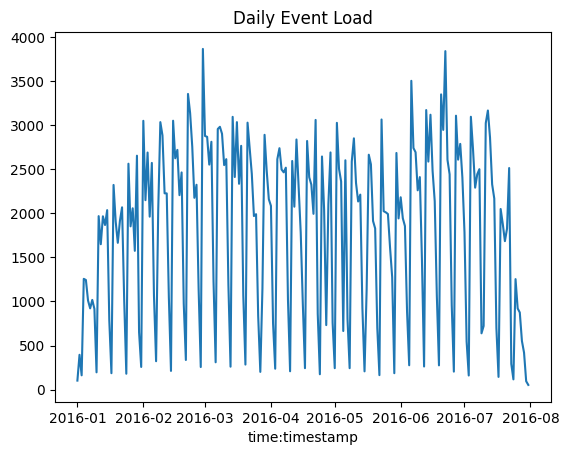


--- Task 19e ---
Avg Delay (Days): 2.3048932222114963e-07

--- Task 20 ---
20d Cases: 521
20e Cases: 3405


In [9]:

# Task 15: Rework
print("--- Task 15 ---")
# Finding successful cases with rework
succ_cases = df[df['case:concept:name'].isin(outcomes[outcomes=='Pending'].index)]
rework_counts = succ_cases.groupby(['case:concept:name', 'concept:name']).size()
rework_cases = rework_counts[rework_counts > 1].index.get_level_values(0).unique()

no_rework = succ_cases[~succ_cases['case:concept:name'].isin(rework_cases)]
rework = succ_cases[succ_cases['case:concept:name'].isin(rework_cases)]

def get_times(d): return d.groupby('case:concept:name')['time:timestamp'].agg(lambda x: x.max()-x.min())

print("No Rework Median:", get_times(no_rework).median())
print("Rework Median:", get_times(rework).median())

# Task 17: Transitions
print("\n--- Task 17 ---")
print(df[df['concept:name'].str.startswith('W_')]['lifecycle:transition'].value_counts().head())

# Task 18: Event Load
print("\n--- Task 18 ---")
df['time:timestamp'].dt.date.value_counts().sort_index().plot(title="Daily Event Load")
plt.show()

# Task 19e: Cancellation Delay
print("\n--- Task 19e ---")
cancelled = df[df['case:concept:name'].isin(outcomes[outcomes=='Cancelled'].index)]
delays = []
for cid, grp in cancelled.groupby('case:concept:name'):
    grp = grp.sort_values('time:timestamp')
    cancel_time = grp.iloc[-1]['time:timestamp'] # Last event is cancelled
    if len(grp) > 1:
        prev_time = grp.iloc[-2]['time:timestamp']
        delays.append((cancel_time - prev_time).total_seconds()/86400)
print("Avg Delay (Days):", np.mean(delays))

# Task 20d & 20e
print("\n--- Task 20 ---")
# 20d: Success + >1 offer + >1 week gap
count_20d = 0
for cid, grp in succ_cases.groupby('case:concept:name'):
    offers = grp[grp['concept:name'] == 'O_Create Offer'].sort_values('time:timestamp')
    if len(offers) > 1 and (offers['time:timestamp'].diff().dt.total_seconds().max() > 7*86400):
        count_20d += 1
print("20d Cases:", count_20d)

# 20e: Cancelled + Call after offers by different officers
count_20e = 0
for cid, grp in cancelled.groupby('case:concept:name'):
    calls = grp[grp['concept:name'] == 'W_Call after offers']
    if len(calls['org:resource'].unique()) > 1:
        count_20e += 1
print("20e Cases:", count_20e)

